This notebook contains code for evaluating the test cases generated by a language model based on a few metrics:

- compile errors
- number of passed tests
- number of failed tests
- branch coverage
- statement coverage

The `coverage` package is used to calcuate the last 4 stats. We can combine these metrics to get a single representing the effectiveness of the generated test cases.

In [1]:
from laughing import metrics

In [2]:
from tqdm import tqdm
from typing import List

def batch_eval(programs: List[str], tests: List[str], cov_output_file:str='cov.json'):
    print('total examples: ', len(programs))
    pbar = tqdm(total=len(programs))
    result = []
    for program, test_cases in zip(programs, tests):      
        try:
          output = metrics.eval_unit_tests(program, test_cases, cov_output_file)
          result.append(output)
        except Exception as ex:
          print(ex)
          result.append({})
        pbar.update(1)

    return result

In [3]:
import json

file = '../data/code_alpaca_with_test_cases.json'
with open(file, encoding='utf-8') as fin:
    data = json.load(fin)


In [6]:
programs = [x['output'] for x in data[0:10]]
tests = [x['test_cases'] for x in data[0:10]]
result = batch_eval(programs, tests)

total examples:  10


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?it/s]T

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.OK

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/si

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.TESTS_FAILED

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/py

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.TESTS_FAILED

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/py

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.OK

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/si

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.OK

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/si

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.TESTS_FAILED

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/py

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.OK

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/si

[Errno 2] No such file or directory: 'cov.json'


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/cmdline.py", line 861, in do_run
    runner.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/execfile.py", line 211, in run
    exec(code, main_mod.__dict__)
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytest/__main__.py", line 5, in <module>
    raise SystemExit(pytest.console_main())
SystemExit: ExitCode.OK

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/coverage/sqlitedb.py", line 109, in _execute
    return self.con.execute(sql, parameters)    # type: ignore[arg-type]
sqlite3.OperationalError: no such table: coverage_schema

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/si

KeyboardInterrupt: 

In [5]:
result

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]

In [34]:
data[15]

{'instruction': 'Write an algorithm in Python to determine if a number is even or odd.',
 'input': '',
 'output': 'def is_even(num): \n    if num % 2 == 0: \n        return True \n    else: \n        return False',
 'test_cases': 'def test_is_even_with_even_number():\n    assert is_even(4) == True, "Test failed! Expected output is True"\n\ndef test_is_even_with_odd_number():\n    assert is_even(3) == False, "Test failed! Expected output is False"\n\ndef test_is_even_with_zero():\n    assert is_even(0) == True, "Test failed! Expected output is True"\n\ndef test_is_even_with_negative_even_number():\n    assert is_even(-2) == True, "Test failed! Expected output is True"\n\ndef test_is_even_with_negative_odd_number():\n    assert is_even(-1) == False, "Test failed! Expected output is False"\n',
 'compile_errors': 0,
 'failed': 0,
 'passed': 5,
 'stm_covered_pct': 1.0,
 'branch_covered_pct': 1.0}

In [35]:
import pandas as pd
tmp = pd.DataFrame(data)

<Axes: >

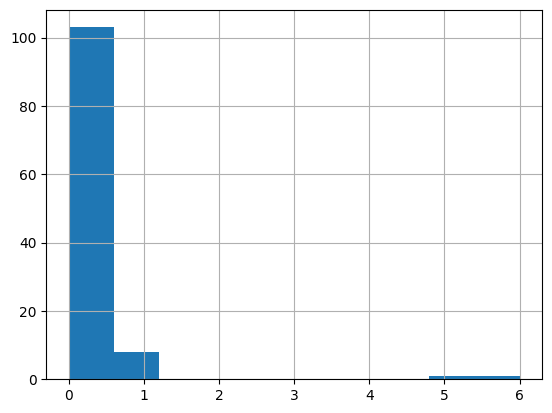

In [45]:
tmp['compile_errors'].hist()

<Axes: >

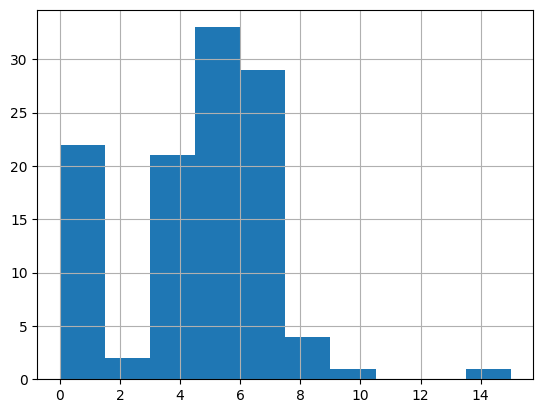

In [46]:
tmp['passed'].hist()

<Axes: >

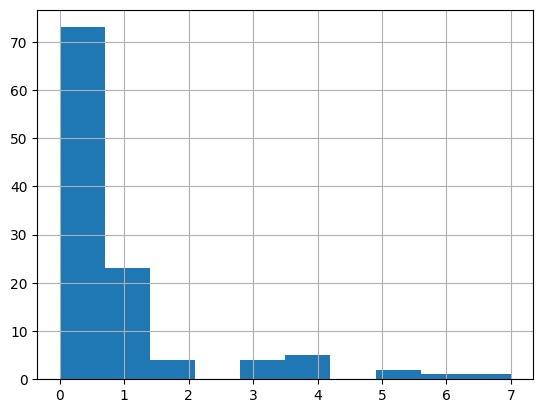

In [47]:
tmp['failed'].hist()